<h1><center>  Project 4: Dynamical processes in networks </center> </h1> 

<center> Bruno Gomes Coelho - 9791160 </center>
<center> Gabriel de Melo Cruz - 9763043 </center>


### Imports

In [12]:
import os
import math
import random
import collections

import scipy
from scipy.linalg import expm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import networkx as nx
#from networkx.algorithms import community
#from community import community_louvain
#from networkx.generators.community import LFR_benchmark_graph
#from networkx.algorithms.community.label_propagation import label_propagation_communities

from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
"""
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__
"""


'\nimport osmnx as ox\nox.config(log_console=True, use_cache=True)\nox.__version__\n'

In [2]:
TESTING = False

### Read all the data we will use through the whole project 

In [13]:
all_graphs = {}
all_graphs["Hamster"] = nx.read_edgelist("data/out.petster-friendships-hamster-uniq", comments="%")

all_graphs["Human Protain"] = nx.read_edgelist("data/out.proteins", comments="%")

all_graphs["C Elegans 2007"] = nx.read_edgelist("data/wi2007.txt", comments="#")

all_graphs["C elegans"] = nx.MultiGraph()
all_graphs["C elegans"] = nx.read_gml("data/celegansneural.gml")
all_graphs["C elegans"] = nx.Graph(all_graphs["C elegans"])
all_graphs["C elegans"] = nx.convert_node_labels_to_integers(all_graphs["C elegans"], first_label=0)

all_graphs["US Airports"] = nx.Graph()
all_graphs["US Airports"] = nx.read_edgelist("data/USairport500.txt", nodetype=int, data=(('weight',float),))

# Convert data to undirected and remove loops
for graph in all_graphs.keys():
    all_graphs[graph] = all_graphs[graph].to_undirected()
    all_graphs[graph].remove_edges_from(nx.selfloop_edges(all_graphs[graph]))

# Q1

In [14]:
def erdos_renyi(N=100, avg_degree=10, p=None):
    if p is None:
        p = avg_degree/(N-1)
    return nx.gnp_random_graph(N, p, seed=None, directed=False)

def barabasi_albert(N=100, avg_degree=10):
    m = int(avg_degree/2)
    return nx.barabasi_albert_graph(N, m)

def watts_strogatz(N=100, avg_degree = 10, p=1):
    k = int(avg_degree/2)
    return nx.watts_strogatz_graph(N, k, p, seed=None)

graphs = {
    "Erdos Renyi": erdos_renyi,
    #"Barabasi Albert": barabasi_albert,
    #"Watts Strogatz (p=0.001)": lambda x, y: watts_strogatz(x, y, p=0.001),
    #"Watts Strogatz (p=0.01)": lambda x, y: watts_strogatz(x, y, p=0.01),
    #"Watts Strogatz (p=0.1)": lambda x, y: watts_strogatz(x, y, p=0.1),
}

In [5]:
def failures(graph):
    G = graph.copy()
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = random.choice(list(G.nodes())) #select the node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

In [6]:
def most_connected(G): # This function is used to find the most connected node
    maxk = 0
    node = 0
    for i in G.nodes():
        if(G.degree(i) >= maxk):
            maxk = G.degree(i)
            node = i
    return node 

def attacks(H):
    G = H.copy()
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = most_connected(G) #select the most connected node on the largest component            
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

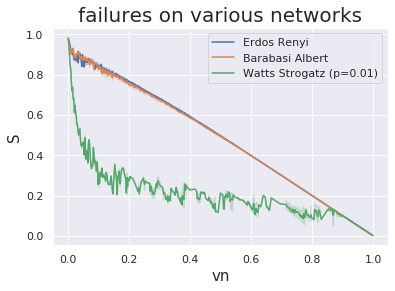

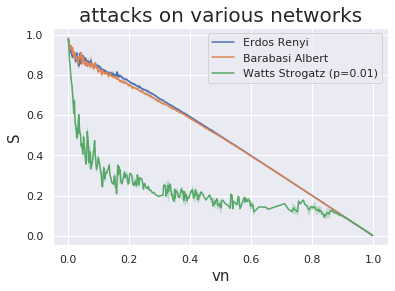

In [7]:
N = 100 if TESTING else 500
REPS = 2 if TESTING else 10

plt.figure()
for func in [failures, attacks]:
    for graph_name, graph_func in graphs.items():
        # Calculate various time the different measures
        S, vn = [], []
        for _ in range(REPS):
            graph = graph_func(N, 10)
            S_, vn_ = failures(graph)
            S += S_
            vn += vn_
        sns.lineplot(S, vn, label=graph_name)
    plt.xlabel("vn", fontsize=15)
    plt.ylabel("S", fontsize=15)
    plt.title(f"{func.__name__} on various networks", fontsize=20)
    plt.show()

By looking at the data we can see that the Watts Strogatz networks are more robust.

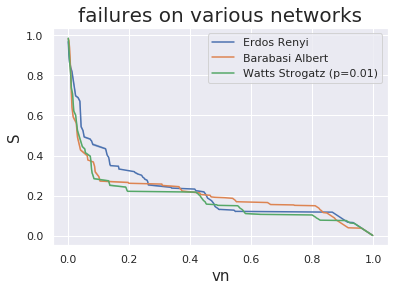

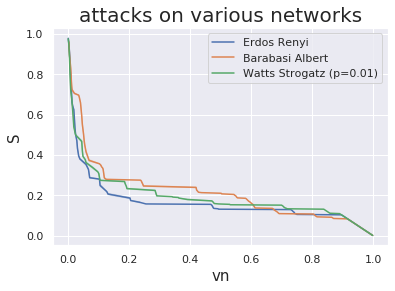

In [9]:
plt.figure()
for func in [failures, attacks]:
    for graph_name, graph in graphs.items():
        # Calculate various time the different measures
        S, vn = [], []
        for _ in range(1):
            graph = graph_func(N, 10)
            S_, vn_ = failures(graph)
            S += S_
            vn += vn_
        sns.lineplot(S, vn, label=graph_name)
    plt.xlabel("vn", fontsize=15)
    plt.ylabel("S", fontsize=15)
    plt.title(f"{func.__name__} on various networks", fontsize=20)
    plt.show()


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q2 - Epidemic spreading

In [15]:
def find(v, i): # function to find the positions of an element in a vector
    l = []
    pos = 0
    for x in v:
        if(x == i):
            l.append(pos)
        pos = pos + 1
    return l


def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes():
        M = M + G.degree(i)**m
    M = M/N
    return M


def epidemic_spread_lambda(G, N, mu, model="SIR", label="Simulation", show=True,
                           theorical_lambda=True, Tmax=10):
    vlbda = list()
    # vector that stores the fraction of infected nodes 
    #     according to the parameter lambda
    rhoI = list() 
    # Stores the time steps
    vt = []
    
    for lbd in np.arange(0,1, 0.05):
        beta = lbd*mu
        av_rho = np.zeros(Tmax)

        for seed_node in G.nodes():
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            infected = list() # Stores the number of infected nodes at each time step
            vrho = list()
            t = 0
            
            # We use a while loop, but manually break in case of SIS
            #while ninfected > 0: 
            while True: 
                # if model == "SIS" and t == Tmax:
                if t == Tmax:
                    break
                vt.append(t)
                t += 1

                infected = find(vector_states, 1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            if model == "SIS":
                                vector_states[j] = 1
                            # verify if the node is not recovered
                            elif vector_states[j] != 2: 
                                vector_states[j] = 1

                # try to recover the infected nodes
                for k in infected: 
                    if np.random.rand() < mu:
                        if model == "SIS":
                            vector_states[k] = 0
                        else:
                            vector_states[k] = 2
                ninfected = len(find(vector_states, 1))
                vrho.append(ninfected/N)
                
            for x in np.arange(0, len(vrho)):
                av_rho[x] = av_rho[x] + vrho[x]
        av_rho = av_rho/len(G.nodes())
        rhoI.append(np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
        vlbda.append(lbd)
        #print(lbd, np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
    
    # Plot
    plt.plot(vlbda, rhoI, 'o--', label=label)
    if theorical_lambda:
        lambda_c = momment_of_degree_distribution(G,1)/momment_of_degree_distribution(G,2)
        plt.axvline(lambda_c, color = 'b', label='Theoretical lambda_c')
    if show:
        plt.xlabel("lambda", fontsize=15)
        plt.ylabel("Fraction of infected nodes", fontsize=15)
        plt.legend()
        plt.grid(True)
        plt.show(True) 

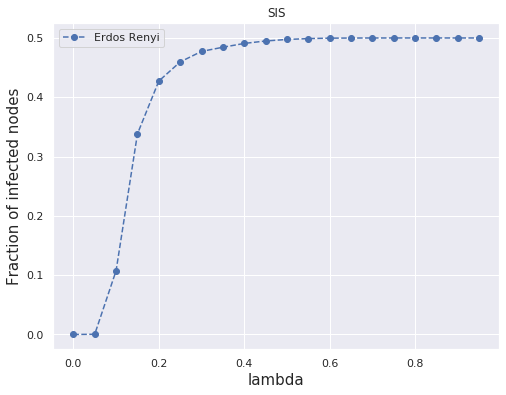

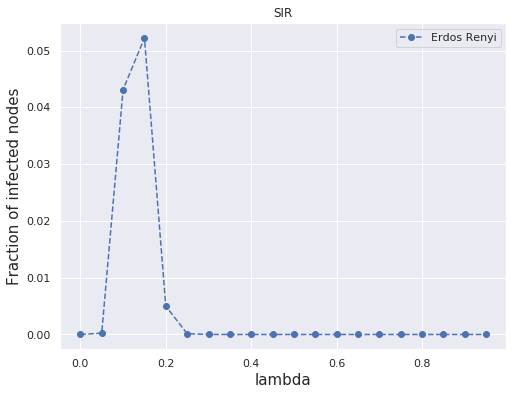

In [16]:
mu = 1  # Probability of recover
N = 10 if TESTING else 500
k = 4 if TESTING else 2*8

for model in ["SIS", "SIR"]:
    plt.figure(figsize=(8,6))
    for graph_name, graph_func in graphs.items():
        graph = graph_func(N, k)
        epidemic_spread_lambda(graph, N, mu, label=graph_name, show=False,
                               theorical_lambda=False, model=model)

    plt.xlabel("lambda", fontsize=15)
    plt.ylabel("Fraction of infected nodes", fontsize=15)
    plt.legend()
    plt.title(model)
    plt.grid(True)
    plt.show(True) 


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q3 - Influential spreaders

In [25]:
def influential_spreader(G, N, mu, beta, label="Simulation"):
    seed_node = 0; # seed node
    vector_states = np.zeros(N) # vector that stores the states of the vertices
    vector_states[seed_node] = 1 # vector that stores the states: 0: Ignorant, 1: spreader, 2: stifler
    ninfected = 1
    t = 0 # start in t= 0 
    infected = list() # Stores the number of infected nodes at each time step
    vt = list() #store the time step
    vrho = list()
    vR = list()
    vS = list()
    # Reactive model
    while ninfected > 0: # Simulate while we can find infected nodes
        infected = find(vector_states,1) # list of infected nodes
        for i in infected: # try to infect the neighbors
            neigs = G.neighbors(i)
            for j in neigs:
                if np.random.rand() < beta:
                    if(vector_states[j] == 0): # verify if the node is an ignorant
                        vector_states[j] = 1
                    else:
                        if(np.random.rand() < mu):
                            vector_states[i] = 2
                            break
        ninfected = len(find(vector_states,1))
        vrho.append(ninfected/N)
        vR.append(len(find(vector_states,2))/N)
        vS.append(len(find(vector_states,0))/N)
        t = t + 1
        vt.append(t)

    plt.figure()
    plt.plot(vt, vrho, 'ro--', label='Spreaders')
    plt.plot(vt, vR, 'bo--', label='Siflers')
    plt.plot(vt, vS, 'go--', label='Ignorants')
    plt.xlabel("t", fontsize=15)
    plt.ylabel("Fraction of nodes in each compartment", fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show(True)

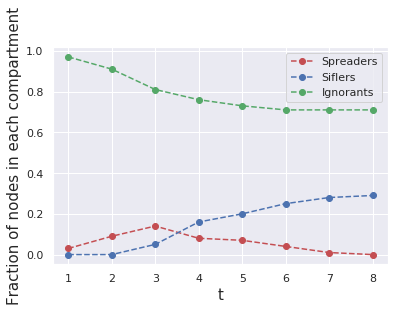

In [26]:


# Network parameters
N = 100 #number of nodes
av_degree = 8 # average degree
p = float(av_degree)/float(N) #probability of connection in the ER model
m = int(av_degree/2) # number of added nodes in the BA model
kappa = av_degree # number of neighbors in the WS model
G = nx.barabasi_albert_graph(N,m)
# Epidemic parameters
beta = 0.3 # Probability of infection
mu = 1  # Probability of recover

influential_spreader(G, N, mu, beta, label="Simulation")



#influential_spreader(all_graphs["US Airports"], len(all_graphs["US Airports"]), 0.8, label="Simulation")
#plt.xlabel("lambda", fontsize=15)
#plt.ylabel("Fraction of infected nodes", fontsize=15)
#plt.legend()
#plt.title(model)
#plt.grid(True)
#plt.show(True) 